In [68]:
from SimPEG import *
from simpegEM1D import (
    EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d, piecewise_pulse,
    EM1DSurveyFD, skytem_HM_2015, skytem_LM_2015
)
import numpy as np
%pylab inline
import matplotlib
matplotlib.rcParams['font.size'] = 14

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['floor', 'axes', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Depth of investigation for AEM data

This notebook illustrates how depth of investigation from Christiansen and Auken (2012) can be 
obtained. using `simpegEM1D` code. 

Anders Vest Christiansen and Esben Auken (2012). ”A global measure for depth of investigation.” GEOPHYSICS, 77(4), WB171-WB177.

https://doi.org/10.1190/geo2011-0393.1


# Background

Basic idea of Christiansen and Auken (2012) is following. Diffusive EM wave propagate downward, and it decays as it propagates deeper. Rate of decay will be dependent upon conductivity (or resistivity) structure. For instance, in a conductive medium EM wave will decay more compared to a resistive medium resulting in smaller DOI. In addition, the latest time channel will includes the deepest information, and hence if noise level of the observation is high then DOI will decrease. 

Christiansen and Auken (2012) used a sensitivity function, $J=\frac{\partial d}{\partial m}$, and data uncertainty ($\triangle d$) to evaluate DOI. Here $d$ is predicted data, and $m$ is an inversion model. So, $J$ includes information about how EM wave decays in earth medium having variable conductivity structure, and data uncertainty correspond to the noise level. 

Important details in their approach are both $d$ and $m$ are logarithmic properties. So, $d=log(\text{voltage})$ and $m=log(\sigma)$; $\triangle d=\% log(\text{voltage})$. 

Let matrix, $\mathbf{G}$, is:

$$ \mathbf{G} = diag(1/\mathbf{\triangle d})\mathbf{J}$$ 

By summing all the rows of $\mathbf{G}$:

$$ s_j = \Sigma_i^{N} G_{ij} $$

Then by integrating $\mathbf{s}$ from bottom layer to the surface layer:

$$ S_j = \Sigma_{k=1}^{j} s_k $$

Here $\mathbf{S}$ is a cumulative sensitivity. 

Dimensions for each of matricies and vectors are:

- $\mathbf{J}$: $N\times M$ 
- $\mathbf{G}$: $N\times M$
- $\mathbf{s}$: $M\times1$ 
- $\mathbf{S}$: $M\times1$
- $\triangle\mathbf{ d}$: N$\times$1

The number of data and model are $M$ and $N$, respectively. 

In the end, we need to choose DOI based upon $\mathbf{S}$, and in the paper they introduced a magic threshold value, 0.8. Any layer having smaller $\mathbf{S}$ value than 0.8 is below the DOI. 

# Examples

As an example, we present two AEM surveys: (1) SkyTEM and (2) Resolve. SkyTEM is a time-domain AEM system, and its base frequency is often 25Hz (or 30Hz depending upon locations). In contrast, Resolve is a frequency-domain AEM system and its lowest frequency is about 400Hz. Hence, our expection of DOI for SkyTEM will be greater than Resolve. 

Following snnipet of codes computes SkyTEM and Resolve responses, then compute DOI for each of them. 

In [21]:
wave_HM = skytem_HM_2015()
wave_LM = skytem_LM_2015()
time_HM = wave_HM.time_gate_center
time_LM = wave_LM.time_gate_center

hz = get_vertical_discretization_time(
    np.unique(np.r_[time_HM, time_LM]), facter_tmax=0.5, factor_tmin=10., n_layer=20
)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
sig_half = 1./30.
sig  = np.ones(hz.size)*sig_half
blk_ind = (-100>LocSigZ) & (-120<LocSigZ)
sig[blk_ind] = 1./5.
blk_ind = (-120>LocSigZ) & (-300<LocSigZ)
sig[blk_ind] = 1./30.
blk_ind = -300>LocSigZ
sig[blk_ind] = 1.
m_true = np.log(sig)

In [22]:
def get_skytem_survey_problem(mesh1D, m_true):
    time_input_currents_HM = wave_HM.current_times[-7:]
    input_currents_HM = wave_HM.currents[-7:]
    time_input_currents_LM = wave_LM.current_times[-13:]
    input_currents_LM = wave_LM.currents[-13:]

    TDsurvey = EM1DSurveyTD(
        rx_location = np.array([0., 0., 100.+30.]),
        src_location = np.array([0., 0., 100.+30.]),
        topo = np.r_[0., 0., 100.],
        depth = depth,
        rx_type = 'dBzdt',
        wave_type = 'general',
        src_type = 'CircularLoop',
        a = 13.,
        I = 1.,
        time = time_HM,
        time_input_currents=time_input_currents_HM,
        input_currents=input_currents_HM,
        n_pulse = 2,
        base_frequency = 25.,
        use_lowpass_filter=True,
        high_cut_frequency=210*1e3,
        moment_type='dual',
        time_dual_moment = time_HM,    
        time_input_currents_dual_moment=time_input_currents_LM,
        input_currents_dual_moment=input_currents_LM,
        base_frequency_dual_moment=210,    
    )
    
    expmap = Maps.ExpMap(mesh1D)

    prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
    if prob.ispaired:
        prob.unpair()
    if TDsurvey.ispaired:
        TDsurvey.unpair()
    prob.pair(TDsurvey)
    prob.chi = np.zeros(TDsurvey.n_layer)
    return TDsurvey, prob

In [69]:
def get_resolve_survey_problem(mesh1D, m_true):
    frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
    FDsurvey = EM1DSurveyFD(
        rx_location = np.array([0., 0., 30.]),
        src_location = np.array([0., 0., 30.]),
        field_type = 'secondary',
        rx_type = 'ppm',
        src_type = 'VMD',
        offset = np.ones_like(frequency)*7.86,
        topo = np.r_[0., 0., 0.],
        depth = depth,
        frequency = frequency
    )
    
    expmap = Maps.ExpMap(mesh1D)
    
    prob = EM1D(
        mesh1D, sigmaMap=expmap,
        chi= np.zeros(FDsurvey.n_layer),
        verbose=False
    )
    if prob.ispaired:
        prob.unpair()
    if FDsurvey.ispaired:
        FDsurvey.unpair()
    prob.pair(FDsurvey)     
    return FDsurvey, prob

(0.5, 100)

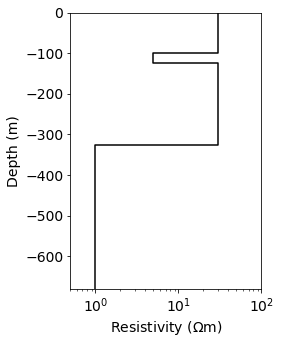

In [70]:
fig, ax = subplots(1,1, figsize=(4, 5))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
ax.set_xlabel("Resistivity ($\Omega$m)")
plt.tight_layout()
fig.savefig('resistivity', dpi=200)
ax.set_xlim(0.5, 100)

In [71]:
survey_skytem, prob_skytem = get_skytem_survey_problem(mesh1D, m_true)
survey_resolve, prob_resolve = get_resolve_survey_problem(mesh1D, m_true)

In [72]:
np.random.seed(1)
dtrue_skytem = survey_skytem.dpred(m_true)
floor = 0.
std = 0.1
noise = std*abs(dtrue_skytem)*np.random.randn(*dtrue_skytem.shape)
survey_skytem.dobs = dtrue_skytem+noise
uncert = abs(survey_skytem.dobs)*std+floor

In [73]:
dtrue_resolve = survey_resolve.dpred(m_true)
floor = 0.
std = 0.1
noise = std*abs(dtrue_resolve)*np.random.randn(*dtrue_resolve.shape)
survey_resolve.dobs = dtrue_resolve+noise
uncert = abs(survey_resolve.dobs)*std+floor

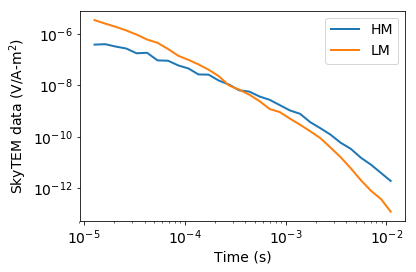

In [74]:
fig, axes = subplots(1,1, figsize = (6,4))
axes.plot(survey_skytem.time, -survey_skytem.dobs[:survey_skytem.n_time], '-', lw=2)
axes.plot(survey_skytem.time_dual_moment, -survey_skytem.dobs[survey_skytem.n_time:], '-', lw=2)
axes.set_xscale('log');
axes.set_yscale('log');
plt.legend(("HM", "LM"))
plt.xlabel("Time (s)")
plt.ylabel("SkyTEM data (V/A-m$^2$)")
plt.tight_layout()

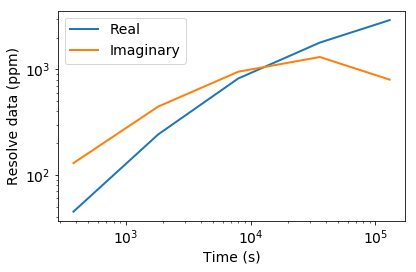

In [75]:
fig, axes = subplots(1,1, figsize = (6,4))
axes.plot(survey_resolve.frequency, survey_resolve.dobs[:survey_resolve.n_frequency], '-', lw=2)
axes.plot(survey_resolve.frequency, survey_resolve.dobs[survey_resolve.n_frequency:], '-', lw=2)
axes.set_xscale('log');
axes.set_yscale('log');
plt.legend(("Real", "Imaginary"))
plt.xlabel("Time (s)")
plt.ylabel("Resolve data (ppm)")
plt.tight_layout()

In [80]:
doi_skytem, actind_skytem = prob_skytem.depth_of_investigation_christiansen_2012(std, thres_hold=0.8)

In [81]:
doi_resolve, actind_resolve = prob_resolve.depth_of_investigation_christiansen_2012(std, thres_hold=0.8)

# Question

Alter the lowest frequency for resolve to 30 Hz, what is the DOI?